# Anomaly Detection with TimeGPT

This notebook demonstrates how to use TimeGPT for detecting anomalies in time-series data. We'll cover:
1. Generating synthetic data with known anomalies
2. Using TimeGPT to detect anomalies
3. Visualizing and evaluating the results

## Introduction

Anomaly detection in time series is crucial for identifying unusual patterns that could indicate:
- System failures
- Fraudulent activities
- Equipment malfunctions
- Other irregular events

TimeGPT provides powerful capabilities for detecting such anomalies by learning normal patterns in the data and identifying deviations from these patterns.

## Setup

First, let's install and import the required packages.

In [1]:
%%capture
!pip install nixtla pandas numpy matplotlib seaborn scikit-learn

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from nixtla import NixtlaClient
from sklearn.metrics import precision_score, recall_score, f1_score

# Set random seed for reproducibility
np.random.seed(42)

# Configure plotting
sns.set_theme(style="whitegrid")
plt.rcParams['figure.figsize'] = [15, 6]

# Initialize Nixtla client
nixtla_client = NixtlaClient(
    api_key='nixak-YdxgHOqWIumbzuaM3A4FiCAaIBp6NLVstE1CjJEnN2Ia9Lu0k6lttUxmz4LZtBNTNV8bYf3owJy6btvb'
)

print("✅ Setup completed successfully")

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


✅ Setup completed successfully


## Synthetic Data Generation

We'll create a synthetic dataset with the following components:
- Trend: Linear upward trend
- Seasonality: Daily and weekly patterns
- Random noise: Normal distribution
- Anomalies: Random spikes and drops

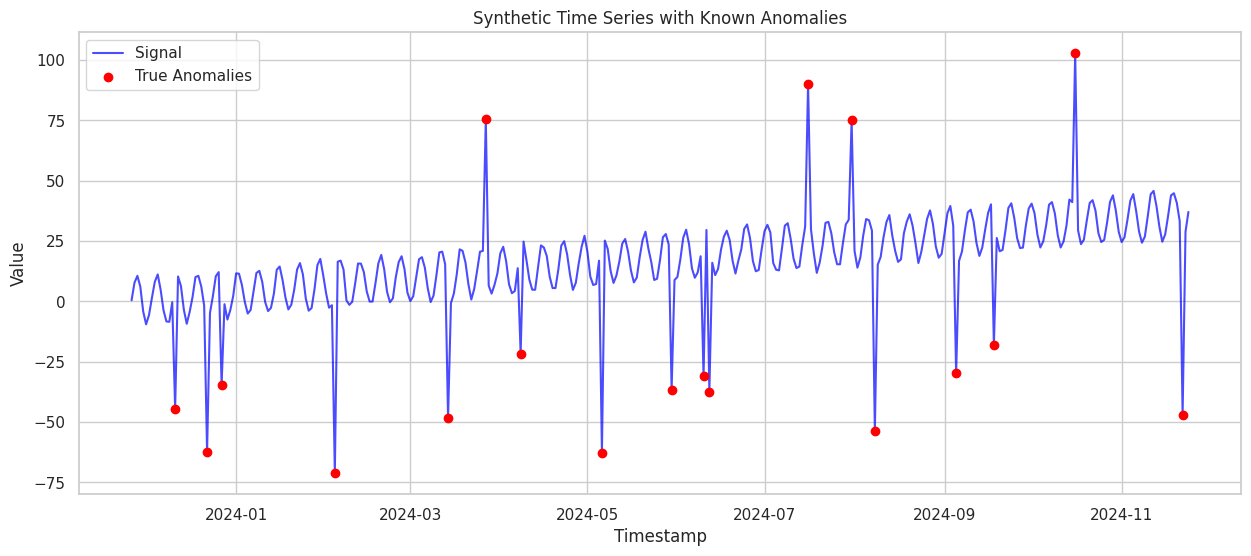

Total points: 365
Number of anomalies: 18
Anomaly percentage: 4.93%


In [3]:
def generate_synthetic_data(days=365, anomaly_percentage=0.05):
    """
    Generate synthetic time series data with known anomalies.

    Parameters:
    -----------
    days : int
        Number of days of data to generate
    anomaly_percentage : float
        Percentage of points that should be anomalies (0-1)

    Returns:
    --------
    pd.DataFrame
        DataFrame with columns: unique_id, ds, y, is_anomaly
    """
    # Generate timestamps
    end_date = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
    start_date = end_date - timedelta(days=days-1)
    timestamps = pd.date_range(start=start_date, end=end_date, freq='D')

    # Generate components
    t = np.arange(len(timestamps))

    # Trend component
    trend = 0.1 * t

    # Seasonal components
    daily_seasonal = 10 * np.sin(2 * np.pi * t / 7)  # Weekly seasonality

    # Base signal (trend + seasonality)
    base_signal = trend + daily_seasonal

    # Add random noise
    noise = np.random.normal(0, 1, len(timestamps))
    signal = base_signal + noise

    # Generate anomalies
    n_anomalies = int(len(timestamps) * anomaly_percentage)
    anomaly_indices = np.random.choice(len(timestamps), n_anomalies, replace=False)
    is_anomaly = np.zeros(len(timestamps), dtype=bool)

    # Add anomalies (spikes and drops)
    for idx in anomaly_indices:
        # Randomly choose between spike and drop
        if np.random.random() < 0.5:
            # Spike: Add 3-5 standard deviations
            signal[idx] += np.random.uniform(3, 5) * np.std(signal)
        else:
            # Drop: Subtract 3-5 standard deviations
            signal[idx] -= np.random.uniform(3, 5) * np.std(signal)
        is_anomaly[idx] = True

    # Create DataFrame
    df = pd.DataFrame({
        'unique_id': 0,
        'ds': timestamps,
        'y': signal,
        'is_anomaly': is_anomaly
    })

    return df

# Generate dataset
df = generate_synthetic_data()

# Plot the synthetic data
plt.figure(figsize=(15, 6))
plt.plot(df['ds'], df['y'], label='Signal', color='blue', alpha=0.7)
plt.scatter(df[df['is_anomaly']]['ds'],
           df[df['is_anomaly']]['y'],
           color='red',
           label='True Anomalies',
           zorder=5)

plt.title('Synthetic Time Series with Known Anomalies')
plt.xlabel('Timestamp')
plt.ylabel('Value')
plt.legend()
plt.show()

print(f"Total points: {len(df)}")
print(f"Number of anomalies: {df['is_anomaly'].sum()}")
print(f"Anomaly percentage: {100 * df['is_anomaly'].mean():.2f}%")

## Anomaly Detection with TimeGPT

Now we'll use TimeGPT to detect anomalies in our synthetic dataset. We'll experiment with different confidence levels to find the optimal setting.


Testing confidence level: 99%
Precision: 0.421
Recall: 0.533
F1 Score: 0.471
Evaluation period: 2024-01-01 00:00:00 to 2024-11-24 00:00:00


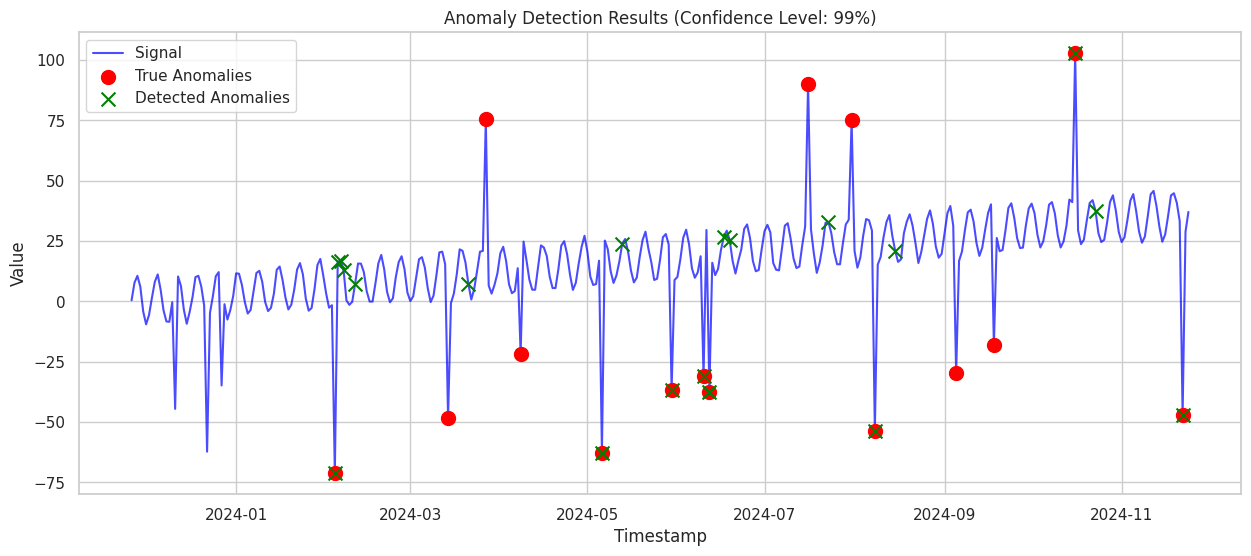


Testing confidence level: 95%
Precision: 0.394
Recall: 0.867
F1 Score: 0.542
Evaluation period: 2024-01-01 00:00:00 to 2024-11-24 00:00:00


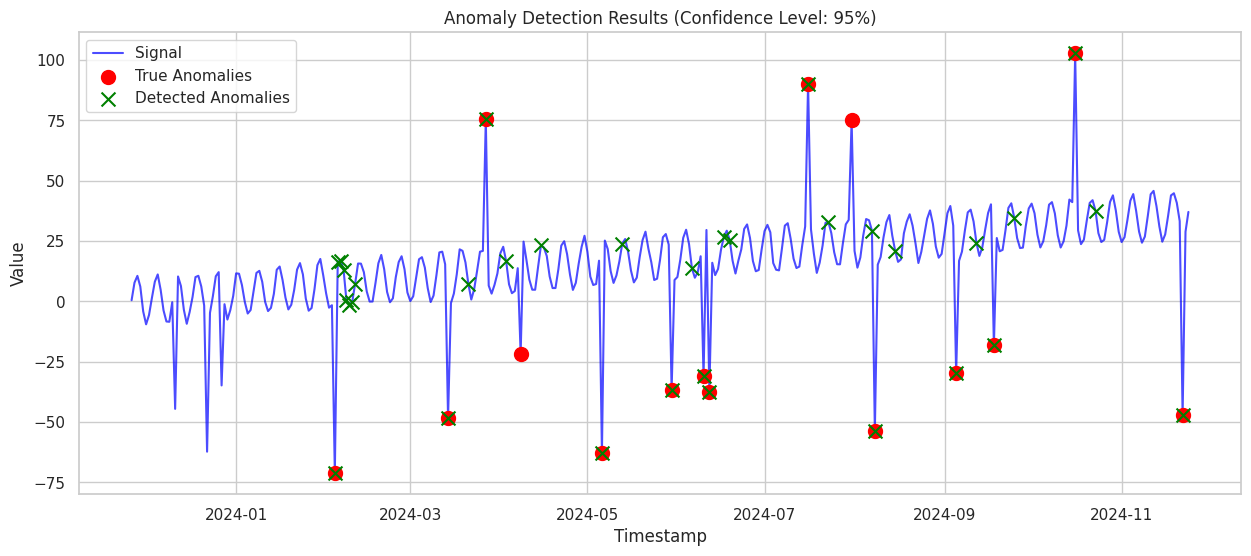


Testing confidence level: 90%
Precision: 0.429
Recall: 1.000
F1 Score: 0.600
Evaluation period: 2024-01-01 00:00:00 to 2024-11-24 00:00:00


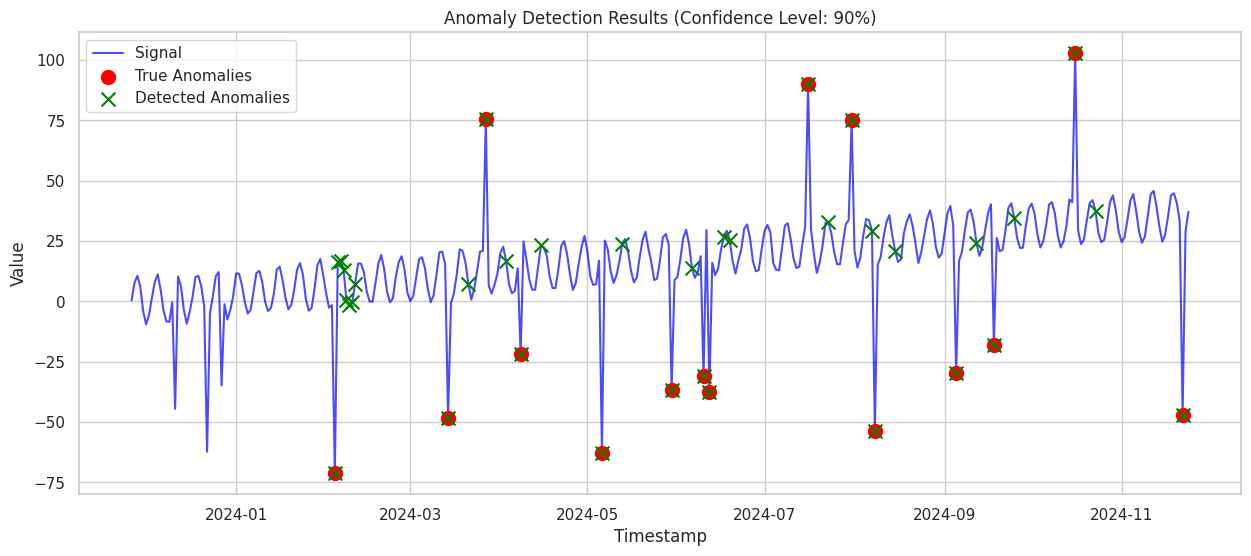

In [4]:
def detect_and_evaluate(df, confidence_level=99):
    """
    Detect anomalies using TimeGPT and evaluate the results.

    Parameters:
    -----------
    df : pd.DataFrame
        Input DataFrame with columns: unique_id, ds, y, is_anomaly
    confidence_level : float
        Confidence level for anomaly detection (0-100)

    Returns:
    --------
    tuple
        (anomalies_df, metrics_dict)
    """
    # Detect anomalies
    anomalies_df = nixtla_client.detect_anomalies(
        df[['unique_id', 'ds', 'y']],  # Only pass required columns
        freq='D',
        level=confidence_level,
        date_features=['month', 'year', 'dayofweek'],  # Add date features
        date_features_to_one_hot=True
    )

    # Align the data for evaluation
    merged_df = pd.merge(df[['ds', 'is_anomaly']],
                        anomalies_df[['ds', 'anomaly']],
                        on='ds',
                        how='inner')

    # Calculate metrics
    metrics = {
        'precision': precision_score(merged_df['is_anomaly'], merged_df['anomaly']),
        'recall': recall_score(merged_df['is_anomaly'], merged_df['anomaly']),
        'f1': f1_score(merged_df['is_anomaly'], merged_df['anomaly'])
    }

    return anomalies_df, metrics, merged_df

# Try different confidence levels
confidence_levels = [99, 95, 90]
results = {}

for level in confidence_levels:
    print(f"\nTesting confidence level: {level}%")
    anomalies_df, metrics, merged_df = detect_and_evaluate(df, level)
    results[level] = (anomalies_df, metrics)

    print(f"Precision: {metrics['precision']:.3f}")
    print(f"Recall: {metrics['recall']:.3f}")
    print(f"F1 Score: {metrics['f1']:.3f}")
    print(f"Evaluation period: {merged_df['ds'].min()} to {merged_df['ds'].max()}")

    # Plot results
    plt.figure(figsize=(15, 6))

    # Plot full signal
    plt.plot(df['ds'], df['y'], label='Signal', color='blue', alpha=0.7)

    # Plot true anomalies
    true_anomalies = merged_df[merged_df['is_anomaly']]
    plt.scatter(true_anomalies['ds'],
               df[df['ds'].isin(true_anomalies['ds'])]['y'],
               color='red',
               label='True Anomalies',
               marker='o',
               s=100,
               zorder=5)

    # Plot detected anomalies
    detected_anomalies = merged_df[merged_df['anomaly']]
    plt.scatter(detected_anomalies['ds'],
               df[df['ds'].isin(detected_anomalies['ds'])]['y'],
               color='green',
               label='Detected Anomalies',
               marker='x',
               s=100,
               zorder=6)

    plt.title(f'Anomaly Detection Results (Confidence Level: {level}%)')
    plt.xlabel('Timestamp')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

## Analysis of Feature Importance

Let's examine which features TimeGPT found most important for anomaly detection.

<Figure size 1200x600 with 0 Axes>

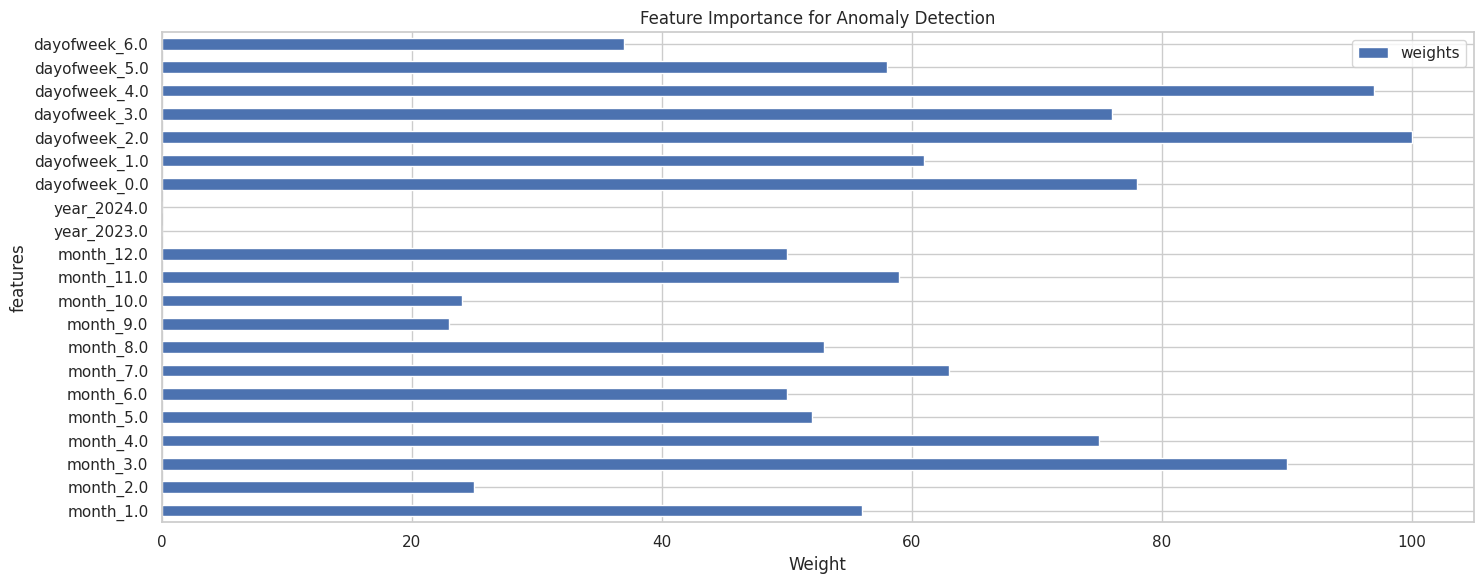

In [5]:
# Plot feature importance
plt.figure(figsize=(12, 6))
nixtla_client.weights_x.plot.barh(x='features', y='weights')
plt.title('Feature Importance for Anomaly Detection')
plt.xlabel('Weight')
plt.tight_layout()
plt.show()

## Conclusion

This notebook demonstrated TimeGPT's capabilities for anomaly detection:

1. We generated synthetic data with known anomalies
2. Used TimeGPT to detect anomalies at different confidence levels
3. Evaluated the results using precision, recall, and F1 score
4. Visualized the results and analyzed feature importance

Key findings:
- Higher confidence levels (99%) are more precise but may miss some anomalies
- Lower confidence levels (90%) catch more anomalies but may have false positives
- Date features help the model understand temporal patterns

For real-world applications, the confidence level should be tuned based on the specific requirements of the use case and the relative cost of false positives versus false negatives.